# 2CS SIQ2-SIL2 TP02. Régression logistique Multi-classes

Dans ce TP, nous allons généraliser la réression linéaire binaire afin de traiter le cas de multiples classes.
Ensuite, dans la partie analyse, nous allons voir quelques méthodes pour traiter le classement multi-classes (cas d'étude, régression logistique).

- **Binôme** **01** : BAZIZ meriem 
- **Binôme** **02** :BOUCETTA Anfal Yousra
- **Groupe** : SIL2

In [ ]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.22.4', '1.4.4', '3.7.1')

In [ ]:
from typing          import Tuple, List, Type
from collections.abc import Callable

**INTRODUCTION**

Nous avons implémenté le cas d'une seule classe (binaire : oui ou non). 
Pour appliquer un classement sur plusieurs classes, nous pouvons entraîner $L$ modèles de régression logistique (où $L$ est le nombre des classes). 
Dans ce cas, nos résultats (Y) doivent encodée en 0 et 1. 
Pour un modèle $M_i$ d'une classe $C_i$, la sortie $Y$ doit avoir 1 si $C_i$, 0 si une autre classe. 
Cette architecture est appelée : One-to-rest classification.

Une autre approche (celle que nous allons implémenter) est d'encoder la sortie en utilisant OneHot encoder. 
Pour $L$ classes et un échantillon donnée, nous allons avoir $L$ sorties (une ayant 1 et les autres 0). 
Pour un dataset avec $M$ échantillons, $N$ caractéristiques et $L$ classes, nous allons avoir les dimensions suivantes : 
- $X [M, N]$
- $Y [M, L]$
- $\theta [N, L]$

Cette dernière approche s'appelle maximum entropy (MaxEnt). 
C'est une généralisation de la régresion logistique binaire.


## I. Réalisation des algorithmes

Cette partie sert à améliorer la compréhension des algorithmes d'apprentissage automatique vus en cours en les implémentant à partir de zéro. 
Pour ce faire, nous allons utiliser la bibliothèque **numpy** qui est utile dans les calcules surtout matricielles.

### I.1. Combinaison linéaire

Les $N$  caractéristiques sont combinées linéairement comme dans la régression linéaire binaire. 
La seule différence est que nous avons plus de classes, donc le nombre des paramètres va être multiplié par le nombre des classes.
La somme pondérée d'une classe $c$ est calculée selon la formule : 

$$Z_c = zfn_c(X, \theta) = \sum\limits_{j=0}^{N} \theta_{(c, j)} X_j | X_0 = 1 $$

La forme matricielle de $Z$ sera : 
$$Z = zfn(X, \theta) = X \cdot \theta$$

- $X[M, N]$      : une matrice de M lignes (échantillons) et N colonnes (caractéristiques, y compris le biais).  
- $\theta[N, L]$ : une matrice de N lignes (caractéristiques, y compris le biais) et L colonnes (classes). 
- $Z[M, L]$      : une matrice de M lignes (échantillons) et L colonnes (classes).

In [ ]:
# TODO: Combinaison linéaire 
def zfn(X: np.ndarray, Theta: np.ndarray) -> np.ndarray: 
    return X@Theta

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[0. , 0. , 0. ],
#        [0.5, 0.1, 0.6],
#        [0.2, 0.3, 0. ],
#        [0.7, 0.4, 0.6]])
#---------------------------------------------------------------------

X_tn = np.array([[0., 0.], 
                 [1., 0.], 
                 [0., 1.], 
                 [1., 1.]]) # 4 échntillons, 2 caractéristiques
Theta_tn = np.array([[0.5, 0.1, 0.6],
                     [0.2, 0.3, 0.0]]) # 2 caractéristiques, 3 classes 

zfn(X_tn, Theta_tn)

array([[0. , 0. , 0. ],
       [0.5, 0.1, 0.6],
       [0.2, 0.3, 0. ],
       [0.7, 0.4, 0.6]])

### I.2. Calcul des probabilités

Les valeurs combinées sont transformées à des probabilités en utilisant la fonction softmax. 
La fonction softmax nous assure que la somme des probabilités des classes soit égale à 1.
Cette fonction prend les combinaisons linéaires $Z[M, L]$ et calcule les probabilités $P[M, L]$ comme suite : 

$$softmax(Z)=\frac{e^Z}{\sum\limits_{k=1}^{L} e^{Z_k}}$$

- $M$ : nombre des échantillons
- $N$ : nombre des caractéristiques
- $L$ : nombre des classes
- La somme des probabilités de chaque ligne doit être 1

In [ ]:
# TODO: Softmax
def softmax(Z: np.ndarray) -> np.ndarray:
    exp_Z = np.exp(Z)
    softmax = exp_Z / np.tile(np.sum(exp_Z,axis=1),(Z.shape[1],1)).T
    return softmax

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[0.33333333, 0.33333333, 0.33333333],
#       [0.36029662, 0.24151404, 0.39818934],
#       [0.34200877, 0.37797814, 0.28001309],
#       [0.37797814, 0.28001309, 0.34200877]])
#---------------------------------------------------------------------
Z_tn = np.array([[0. , 0. , 0. ],
                 [0.5, 0.1, 0.6],
                 [0.2, 0.3, 0. ],
                 [0.7, 0.4, 0.6]])
softmax(Z_tn)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

### I.3. Prédiction 

Etant donnée les probabilités des classes pour chaque échantillon, nous devons choisir la classe avec le max de probabilité.

$$
\hat{C}^{(i)}_j = 
\begin{cases}
1 & si & H^{(i)}_j \ge \max P^{(i)}\\
0 & sinon & \\
\end{cases}
$$

- $H[M, L]$ probabilités où chaque ligne est un échantillon et chaque colonne est une classe
- $\hat{C}[M, L]$ prédictions où chaque ligne est un échantillon et chaque colonne est une classe. $\hat{C}^{(i)}_j \in \{0, 1\}$

Lorsqu'il y a deux colonnes ou plus ayant le même max, nous prenons la première.

In [ ]:
# TODO: Prédictions multiclasses
def cn(H: np.ndarray) -> np.ndarray:
    # Get the index of the maximum value in each row of H
    max_index = np.argmax(H, axis=1)
    C = np.zeros_like(H)
    C[np.arange(H.shape[0]), max_index] = 1
    
    return C
#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[1, 0, 0],
#        [0, 0, 1],
#        [0, 1, 0],
#        [1, 0, 0]])
#---------------------------------------------------------------------

H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
             [0.36029662, 0.24151404, 0.39818934],
             [0.34200877, 0.37797814, 0.28001309],
             [0.37797814, 0.28001309, 0.34200877]])
cn(H_tn)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

### I.4. Calcul du coût 

Nous référons aux probabilités calculées par la fonction softmax comme $H$, où $H_c$ est la probabilité d'une classe $c$.
Etant donné un échantillon $X^{(i)}$, son coût est calculé comme : 

$$ cout(H^{(i)}, Y^{(i)}) = - \sum\limits_{c=1}^{L} Y^{(i)}_c \log(H^{(i)}_c)$$

Le coût total est la moyenne des coût de tous les échantillons

$$J(H, Y) = \frac{1}{M} \sum\limits_{i=1}^{M} cout(H^{(i)}, Y^{(i)})$$

- $H[M, L]$ : les probabilités estimées de chaque échantillon (M) de chaque classe (L)
- $Y[M, L]$ : les probabilités réelles (1 ou 0) de chaque échantillon (M) de chaque classe (L)

In [ ]:
# TODO: Coût du classement multiclasses 
def jn(H: np.ndarray, Y: np.ndarray) -> np.ndarray:
    M = Y.shape[0]
    cout = -np.sum(Y*np.log(H))
    return 1/M*np.sum(cout)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 1.1913194530574498
#---------------------------------------------------------------------

H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])

jn(H_tn, Y_tn)

1.1913194530574498

### I.5. Calcul des gradients

La taille des gradients est la même que celle des paramètres $\theta[N, L]$. 

$$\frac{\partial J}{\theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (H^{(i)} - Y^{(i)}) X^{(i)}_{j} $$

Sa forme matricielle sera 
$$\frac{\partial J}{\theta_j} = \frac{1}{M} X^\top \cdot (H-Y) $$

- $X[M, N]$ : une matrice de M lignes (échantillons) et N colonnes (caractéristiques, y compris le biais).  
- $H[M, L]$ : les probabilités estimées de chaque échantillon (M) de chaque classe (L)
- $Y[M, L]$ : les probabilités réelles (1 ou 0) de chaque échantillon (M) de chaque classe (L)
- $\frac{\partial J}{\theta}[N, L]$ : une matrice de L lignes (classes) et N colonnes (caractéristiques, y compris le biais). 

In [ ]:
# TODO: Gradients multiclasses
def dJn(X: np.ndarray, H: np.ndarray, Y: np.ndarray) -> np.ndarray:
    M = Y.shape[0]
    return 1/M*X.T @ (H-Y)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[-0.06543131, -0.11961822,  0.18504953],
#        [-0.07000327,  0.16449781, -0.09449454]])
#---------------------------------------------------------------------
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
H_tn = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])

dJn(X_tn, H_tn, Y_tn)

array([[-0.06543131, -0.11961822,  0.18504953],
       [-0.07000327,  0.16449781, -0.09449454]])

### I.6. Descente du gradient adaptative

**Rien à programmer ici**

In [ ]:
def descente(X, Y, Theta, ITER=100, alpha=0.1):
    couts = []

    Theta = Theta.copy() # pour ne pas modifier Theta original
    
    for i in range(ITER): # Ici, la seule condition d'arrêt est le nombre des itérations
        H = softmax(zfn(X, Theta))
        couts.append(jn(H, Y))
        Theta = Theta - alpha * dJn(X, H, Y)
    
    return Theta, couts



### I.7. Regrouper les fonctions ensemble 

Pour bien gérer l'entraînement et la prédiction, les fonctions que nous avions implémentées sont regroupées dans une seul classe. 
L'intérêt : 
- Si nous appliquons la normalisation durant l'entraînement, nous devons l'appliquer aussi durant la prédiction. En plus, nous devons utiliser les mêmes paramètres (moyenne et écart-type)
- Nous utilisons les thétas optimales lors de la prédicition.


In [ ]:
def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std

def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

class MaxEnt(object):
    
    def __init__(self, norm=True, const=True): 
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y, max_iter=100, alpha=.01): 
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const)
        Theta = np.zeros((X_pre.shape[1], Y.shape[1])) # Theta[N, L]
        self.Theta, self.couts = descente(X_pre, Y, Theta, ITER=max_iter, alpha=alpha)
        
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True):
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = softmax(zfn(X_pre, self.Theta))
        if prob:
            return H
        return cn(H)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([[1, 0, 0],
#        [0, 1, 0],
#        [0, 1, 0],
#        [0, 0, 1]])
#---------------------------------------------------------------------
X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]]) # deux variables logiques
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]]) # égale, sup, inf, égale

X_testn = np.array([[2., 2.], [1., 0.], [1., -1.], [2., 5.]])

maxent = MaxEnt()
maxent.entrainer(X_tn, Y_tn)
maxent.predire(X_testn, prob=False)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## II. Application et analyse

Nous allons utiliser [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) pour classer des fleurs en trois classes, en utilisant 4 caractéristiques. 
Pour simplification, nous allons utiliser seulement 2 caractéristiques : Petal Length (cm); Petal Width (cm). 
D'après [Ce tutoriel](https://teddykoker.com/2019/06/multi-class-classification-with-logistic-regression-in-python/) ces deux caractéristiques sont suffisantes.


In [ ]:
iris = pd.read_csv('sample_data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
if iris.shape[1] > 3:
    iris.drop(['sepal_length', 'sepal_width'], axis = 1, inplace=True)
iris.head()

,petal_length,petal_width,class
0,1.4,0.2,Iris-setosa
1,1.4,0.2,Iris-setosa
2,1.3,0.2,Iris-setosa
3,1.5,0.2,Iris-setosa
4,1.4,0.2,Iris-setosa


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# https://www.kaggle.com/datasets/kukuroo3/body-performance-data
body = pd.read_csv('sample_data/bodyPerformance.csv')

# transformer le sex en un vecteur de deux elements et supprimer le
gender = OneHotEncoder().fit_transform(body[['gender']]).toarray()
body.drop(['gender'], axis=1, inplace=True)
body.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [ ]:
from sklearn.model_selection import train_test_split

Xbody = body.iloc[:, :-1].values # Premières colonnes 

# Ajouter le sex encodé aux caractéristiques
Xbody = np.concatenate((Xbody, gender), axis=1)

Ybody = body.iloc[:,  -1].values # Dernière colonne   

Xbody_train, Xbody_test, Ybody_train, Ybody_test = train_test_split(Xbody, Ybody, 
                                                                    test_size   =0.2, # 20% pour le teste
                                                                    random_state=0, 
                                                                    stratify    =Ybody) # stratification sur Yiris


Xbody_train.shape, Xbody_test.shape

NameError: ignored

### II.1. Séparabilité des classes

Ici, nous allons vérifier la séparabilité des classes visuellement (en se basant sur les deux caractéristiques).

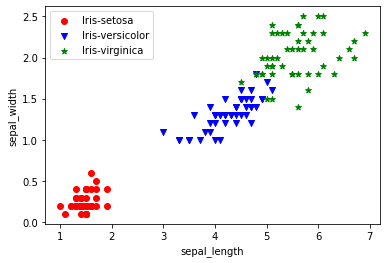

In [ ]:
Xiris = iris.iloc[:, :-1].values # Premières colonnes 

Yiris = iris.iloc[:,  -1].values # Dernière colonne 

setosa     = iris['class'] == 'Iris-setosa'
versicolor = iris['class'] == 'Iris-versicolor'
virginica  = iris['class'] == 'Iris-virginica'

plt.scatter(Xiris[setosa,     0], Xiris[setosa,     1], color='red'  , marker='o', label='Iris-setosa'    )
plt.scatter(Xiris[versicolor, 0], Xiris[versicolor, 1], color='blue' , marker='v', label='Iris-versicolor')
plt.scatter(Xiris[virginica,  0], Xiris[virginica,  1], color='green', marker='*', label='Iris-virginica' )

plt.xlabel('sepal_length')
plt.ylabel('sepal_width' )
plt.legend()
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous concernant la séparabilité des 3 classes?
- Donner une hypothèse concernant la performance d'un modèle de classement comme la régression logistique sur ce dataset (Rappel, Précision)
- Justifier cette hypothèse (Rappel, Précision) en comparant les 3 classes

**Réponse**
- La  classe iris-setosa est facilement séparable des deux autres, mais il faudra un peu plus d'entrainement pour le modèle afin de séparer les classes iris-virginica et iris-versicolor car ces dernières se chevauchent

- L'application de la regression logistique est en mesure d'obtenir une précision et un rappel élevés car le dataset forme un ensemble de données relativement simple qui contient trois classes équillibrés chacunes ayant des caractéristiques distinctes (peux de chevauchement) par example pour la classe iris-setosa on peut atteindre un rappel et une précision =1

- Vue que les différentes classes sont relativement distinctes, il est probable que le modèle de régression logistique soit capable de bien distinguer entre les différentes classes et donc de produire des résultats de classification précis. Par conséquent, il est raisonnable de s'attendre à ce que la précision du modèle soit élevée .d'autre part, comme le dataset iris est équilibré, cela signifie que le nombre d'exemples dans chaque classe est à peu près le même. Par conséquent, le modèle sera entraîné sur un nombre égal d'exemples de chaque classe, ce qui devrait aider à minimiser les biais de classe dans les prédictions du modèle , car chaque classe est traitée de manière équivalente pendant l'entraînement.Cela signifie que le rappel du modèle, qui mesure la proportion de vrais positifs (i.e. la capacité à identifier correctement une classe donnée) devrait également être élevé.

In [ ]:
from sklearn.model_selection import train_test_split  

Xiris_train, Xiris_test, Yiris_train, Yiris_test = train_test_split(Xiris, Yiris, 
                                                                    test_size   =0.2, # 20% pour le teste
                                                                    random_state=0, 
                                                                    stratify    =Yiris) # stratification sur Yiris

len(Xiris_train), len(Xiris_test), np.unique(Yiris_test, return_counts=True)

(120,
 30,
 (array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object),
  array([10, 10, 10])))

### II.2. One-vs-Rest OU MaxEnt

Nous avons entrainé deux modèles : 
1. **One-vs-Rest** : ici, trois sous-modèles binaires sont entraînés ; un pour chaque class. Chaque sous modèle détecte si l'échantillon appartient à sa classe ou non. Lors de la prédiction, on prend la classe avec le max de probabilité
1. **MaxEnt** : ici, un modèle de régression logistique multinomiale (maximum entropy) est entraîné pour séparer les trois classes


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

one2rest = LogisticRegression(solver='lbfgs', penalty=None, multi_class='ovr'        )
one2one  = LogisticRegression(solver='lbfgs', penalty=None, multi_class='multinomial')

one2rest.fit(Xiris_train, Yiris_train)
one2one .fit(Xiris_train, Yiris_train)

print('One-vs-Rest')
print(classification_report(Yiris_test, one2rest.predict(Xiris_test)))

print('MaxEnt')
print(classification_report(Yiris_test, one2one.predict(Xiris_test)))

One-vs-Rest
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

MaxEnt
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



**TODO : Analyser les résultats**

Nous remarquons que la performance de MaxEnt est meilleure que celle de One-vs-Rest
- Pourquoi ? (en se basant sur la limite de décision et les paramètres)
- Quelle est l'approche (parmi ces deux) qui est affectée beaucoup plus par les valeurs aberrantes (les échantillons d'une classe qui peuvent se retrouver aux milieu d'une autre classe)

**Réponse**
-  Maximum Entropy (MaxEnt) est plus robuste que OvR car il est moins sensible aux échantillons qui se trouvent près de la frontière de décision (valeurs aberantes). La raison en est que MaxEntropy prend en compte les différentes classes simultanément lors de la classification, ce qui permet de mieux prendre en compte les relations entre elles et d'améliorer la précision de la classification. Alors que dans l'approche OvR, chaque classe est comparée à toutes les autres classes de manière indépendante, ce qui peut entraîner des conflits et des ambiguïtés dans la classification.

- l'approche qui est affecté le plus par les valeurs aberrantes est OvR ,cela est du au fait qu'il traite chaque classe séparément en utilisant des modèles de classification binaires,Par exemple, supposons que nous ayons trois classes : A, B et C. Dans l'approche OvR, nous construisons trois classificateurs binaires : A vs (B+C), B vs (A+C) et C vs (A+B). Si une instance est proche de la frontière entre la classe A et la classe B, elle peut être classée à tort comme appartenant à la classe C, car les classificateurs pour A vs (B+C) et B vs (A+C) peuvent tous les deux avoir des scores faibles pour cette instance.

### II.3. One-vs-Rest OU One-vs-One

Nous avons entrainé deux modèles : 
1. One-vs-Rest
1. One-vs-One

Les deux modèles sont comparés en se basant sur plusieurs critères.

In [ ]:
# https://goshippo.com/blog/measure-real-size-any-python-object/
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import sys, timeit
from sklearn.metrics import accuracy_score

# ce block du code est pour filtrer les avertissements concernant la convergence du modèle
# en général, lorsque e nombre des itérations n'est pas suffisant pour atteindre l'erreur minimale
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1))
ovo = OneVsOneClassifier (LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1))

temps_train = []

temps_debut = timeit.default_timer()
ovr.fit(Xbody_train, Ybody_train)
temps_train.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
ovo.fit(Xbody_train, Ybody_train)
temps_train.append(timeit.default_timer() - temps_debut)

temps_test = []

temps_debut = timeit.default_timer()
ovr_res = ovr.predict(Xbody_test)
temps_test.append(timeit.default_timer() - temps_debut)

temps_debut = timeit.default_timer()
ovo_res = ovo.predict(Xbody_test)
temps_test.append(timeit.default_timer() - temps_debut)

taille = [get_size(ovr), get_size(ovo)]

accuracy = [
    accuracy_score(Ybody_test, ovr_res),
    accuracy_score(Ybody_test, ovo_res)
]


pd.DataFrame({
    'Algorithme'            : ['OvR', 'OvO']  ,
    'Taille'                : taille,
    'Temps d\'entrainement' : temps_train,
    'Temps de test'         : temps_test,
    'Accuracy'              : accuracy,
})

NameError: ignored

**TODO : Analyser les résultats**

- Pourquoi la taille OvO est plus grande que celle de OvR ?
- Le temps d'entrainement est différent d'une exécution à une autre. Quand est-ce que un modèle est plus rapide que l'autre ?
- Par contre, le temps de test OvO est plus lourd. Pourquoi?
- Si nous pouvons paralleliser tous les modèles binaires, quel est l'effet sur les deux ?
- Pourquoi OvO généralise-t-il mieux que OvR ?
- Pouvons-nous utiliser OvR pour multi-label ? Pourquoi ?
- Pouvons-nous utiliser OvO pour multi-label ? Pourquoi ?

**Réponse**
- La taille de OvO est plus grande que OvR car OVO nécessite la formation de N(N-1)/2 modèles binaires pour N classes, tandis que OVR nécessite la formation de N modèles binaires. Ainsi, OVO est plus coûteux en termes de temps et de **mémoire** (pour stocker les paramètres du modèle) que OVR.

- Lorsque le nombre de classes est élevé, le nombre de classificateurs binaires requis pour OvO peut devenir très grand, ce qui peut augmenter le temps de calcul et la mémoire nécessaires pour stocker les paramètres de modèle. Dans ce cas, OvR peut être plus rapide et plus efficace car il ne nécessite que k classificateurs binaires.Cependant, lorsque le nombre de classes est relativement petit, le nombre de classificateurs binaires requis pour OvO est plus faible et peut être plus rapide et plus efficace que OvR. En effet, avec OvO, les classificateurs binaires ne sont entraînés que sur des sous-ensembles de données contenant deux classes, ce qui peut être plus rapide que l'entraînement de k classificateurs binaires pour OvR ou chaque classificateur binaire est entraîné sur tout l'ensemble de données.

- Le temps de test pour OvO est plus lourd que pour OvR en raison du nombre de classificateurs binaires nécessaires pour OvO. Avec OvO, un classificateur binaire est entraîné pour chaque paire de classes distinctes, ce qui signifie que le nombre total de classificateurs binaires requis est de (K*(K-1))/2, où K est le nombre de classes. Par conséquent, si le nombre de classes est élevé, le nombre de classificateurs binaires requis pour OvO peut devenir très grand, ce qui peut augmenter le temps de prédiction lors du test.Avec OvO, chaque instance de test doit être évaluée par tous les classificateurs binaires, puis le vote majoritaire est utilisé pour déterminer la classe finale. Par conséquent, si le nombre de classes est très grand, le temps de test peut devenir très coûteux en termes de temps de calcul et de ressources nécessaires.
En revanche, avec l'approche OvR, chaque instance de test est évaluée par un seul classificateur binaire créé lors de l'entraînement. Ainsi, le temps de test est généralement plus rapide que pour l'approche OvO, même si le nombre de classificateurs binaires créés peut être plus élevé.

- Avec OvO, chaque classificateur binaire travaille sur un sous-ensemble de données contenant deux classes, de sorte que chaque classificateur binaire peut être entraîné indépendamment des autres. Si nous pouvons paralléliser l'entraînement de tous les classificateurs binaires, cela peut accélérer considérablement le temps d'entraînement de l'ensemble du modèle.
De même, avec OvR, chaque classificateur binaire travaille sur toutes les données à l'exception d'une seule classe. Si nous pouvons paralléliser l'entraînement de chaque classificateur binaire, cela peut également accélérer le temps d'entraînement de l'ensemble du modèle.
En résumé, si nous pouvons paralléliser l'entraînement des classificateurs binaires, cela peut accélérer le temps d'entraînement de l'ensemble du modèle pour les deux approches de classification, mais le choix entre OvO et OvR dépendra toujours du nombre de classes et de la taille des données.
Cependant, même si nous pouvons paralléliser l'entraînement des classificateurs binaires, le nombre de classificateurs binaires requis pour OvO peut encore être très grand si le nombre de classes est élevé. Dans ce cas, OvR peut toujours être plus efficace en termes de temps d'entraînement et de mémoire requise pour stocker les paramètres du modèle.

- L'une des raisons pour lesquelles OvO peut généraliser mieux est qu'il réduit le risque de surajustement (overfitting) par rapport à OvR. En effet, avec OvO, chaque classificateur binaire est entraîné sur un sous-ensemble de données contenant seulement deux classes, ce qui peut être bénéfique lorsque le nombre de classes est élevé et les données sont très hétérogènes. Cela peut permettre aux classificateurs binaires d'être plus adaptés aux caractéristiques spécifiques de chaque paire de classes, plutôt que de créer un seul classificateur pour toutes les classes.
En outre, l'approche OvO peut également aider à améliorer la précision globale du modèle, car elle utilise le vote majoritaire pour déterminer la classe finale. Cela peut aider à compenser les erreurs de classification individuelles des classificateurs binaires et améliorer la performance globale du modèle.

- oui,La classification multilabel consiste à entraîner un classificateur binaire pour chaque étiquette en considérant cette étiquette par rapport à toutes les autres étiquettes combinées ,mais la méthode OvR suppose que les étiquettes sont indépendantes les unes des autres, ce qui peut ne pas être vrai pour tous les problèmes de classification multi-étiquettes. Dans les cas où les étiquettes sont fortement corrélées cela peut conduire à une performance médiocre.

- Oui, on pourrait construire plusieurs classificateurs indépendants et ensuite choisir la classe pour laquelle la confiance est maximisée.
cela revient à évaluer l'appartenance de l'instance a plusieurs classes différentes (multilabel)

- Non ,Dans la classification multi-label un exemple peut appartenir à plus d'une classe, l'utilisation de la méthode OvO peut devenir coûteuse en termes de calcul et nécessiter l'apprentissage d'un grand nombre de classificateurs, en particulier s'il y a beaucoup de classes.

In [ ]:
'FIN du TP ... Enfin! :)'

'FIN du TP ... Enfin! :)'